In [1]:
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torch.utils.data 
from torch.autograd import Variable 
from torchvision import(
    datasets, 
    transforms, 
    models, 
    utils,)

In [2]:
# Training Parameters 
batch_size = 64 
learning_rate = 0.01 
dropout_p = 0.35 
color_scale = 1 
num_hidden_units = 50 
num_classes = 10 
max_grad_norm = 5.0 

# Use GPU 
cuda = torch.cuda.is_available() 

# Reproduceability 
seed = 42 
torch.manual_seed(seed) 
if cuda: 
    torch.cuda.manual_seed(seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist', train=True, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.15,), (0.35,)) ])), batch_size=batch_size, shuffle=True) 

test_loader = torch.utils.data.DataLoader( 
    datasets.MNIST('data/mnist', train=False, download=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.15,), (0.35,)) ])), batch_size=batch_size, shuffle=True)

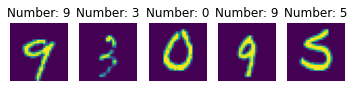

In [4]:
# Visualize 
batch = next(iter(test_loader)) 
samples = batch[0][:5] 
y_true = batch[1] 
for i, sample in enumerate(samples): 
    plt.subplot(1, 5, i+1) 
    plt.title('Number: %i' % y_true[i]) 
    plt.imshow(sample.numpy().reshape((28,28))) 
    plt.axis('off')

In [5]:
class CNN(nn.Module): 
    def __init__(self, dropout_p, num_hidden_units, num_classes): 
        super(CNN, self).__init__() 
        self.conv1 = nn.Conv2d(color_scale, 10, kernel_size=5) 
        self.pool1 = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.dropout_conv2 = nn.Dropout2d(dropout_p) 
        self.pool2 = nn.MaxPool2d(2,2) 
        self.fc1 = nn.Linear(20*4*4, num_hidden_units) 
        self.fc2 = nn.Linear(num_hidden_units, num_classes) 
        
    def forward(self, x_input): 
        x = self.pool1(F.relu(self.conv1(x_input))) 
        x = self.dropout_conv2(F.relu(self.pool2(self.conv2(x)))) 
        x = x.view(-1,20*4*4) 
        x = F.relu(self.fc1(x)) 
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x)
        return x

In [6]:
# Initialize Model 
cnn = CNN(dropout_p, num_hidden_units, num_classes) 
if cuda: 
    cnn.cuda() 
optimizer = optim.Adagrad(cnn.parameters(), lr = learning_rate) 
loss_func = torch.nn.CrossEntropyLoss()

In [7]:
def fit(model, train_loader): 
    epochs = 5 
    model.train() 
    for epoch in range(epochs): 
        correct = 0 
        for idx, (X_batch, y_batch) in enumerate(train_loader):
            if cuda:
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()
            var_X_batch = Variable(X_batch).float() 
            var_y_batch = Variable(y_batch) 
            optimizer.zero_grad() 
            y_hat = model(var_X_batch) 
            loss = loss_func(y_hat, var_y_batch) 
            loss.backward() 
            optimizer.step() 
            
            # Total correct predictions 
            predicted = torch.max(y_hat.data, 1)[1] 
            correct += (predicted == var_y_batch).sum() 
            #print(correct) 
        print('Epoch: {} \tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, loss.data, float(correct*100) / float(batch_size*(idx+1))))

In [8]:
fit(cnn,train_loader)

Epoch: 0 	Loss: 0.422705	 Accuracy:86.172%
Epoch: 1 	Loss: 0.158410	 Accuracy:92.326%
Epoch: 2 	Loss: 0.304091	 Accuracy:93.658%
Epoch: 3 	Loss: 0.042410	 Accuracy:94.048%
Epoch: 4 	Loss: 0.200602	 Accuracy:94.631%


In [9]:
def evaluate(model): 
    correct = 0 
    for test_imgs, test_labels in test_loader:
        if cuda:
            test_imgs = test_imgs.cuda()
            test_labels = test_labels.cuda()
        test_imgs = Variable(test_imgs).float() 
        y_hat = model(test_imgs) 
        predicted = torch.max(y_hat,1)[1] 
        correct += (predicted == test_labels).sum() 
    print("Test accuracy:{:.3f}% ".format( 100 * float(correct) / (len(test_loader)*batch_size)))

In [10]:
evaluate(cnn)

Test accuracy:94.616% 


In [11]:
def infer(model,inputs): 
    if cuda: 
        inputs = inputs.cuda() 
    with torch.no_grad(): 
        X_batch = Variable(inputs, requires_grad=False) 
        scores = model(X_batch) 
        score, predicted = torch.max(scores,1) 
    return predicted

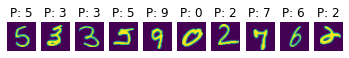

In [12]:
# Visualize Predictions 
batch = next(iter(test_loader)) 
samples = batch[0][:10] 
y_preds = infer(cnn,samples) 
for i, sample in enumerate(samples): 
    plt.subplot(1, 10, i+1) 
    #Use P as symbol for Prediction 
    plt.title('P: %i' % y_preds[i].data) 
    plt.imshow(sample.numpy().reshape((28,28))) 
    plt.axis('off')